In [ ]:
%pip install tensorflow opencv-python matplotlib

In [ ]:
import tensorflow as tf
import os

In [3]:
# Avoid OOM error by setting up GPU memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
import cv2
import imghdr

/tmp/ipykernel_11837/4232469594.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [7]:
data_dir='data'
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [16]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)
            

In [ ]:
tf.data.Dataset


In [17]:
import numpy as np
from matplotlib import pyplot as plt

In [18]:
data =tf.keras.utils.image_dataset_from_directory('data')

Found 146 files belonging to 2 classes.


In [19]:
data_iterator = data.as_numpy_iterator()

In [29]:
batch =data_iterator.next()

(array([[[[177.09215  , 148.09215  , 134.09215  ],
          [178.       , 149.       , 135.       ],
          [179.07402  , 150.07402  , 134.07402  ],
          ...,
          [234.       , 219.       , 200.       ],
          [234.       , 219.       , 200.       ],
          [234.       , 219.       , 200.       ]],
 
         [[177.7802   , 148.7802   , 134.7802   ],
          [178.24925  , 149.24925  , 135.24925  ],
          [179.74083  , 150.74083  , 134.74083  ],
          ...,
          [234.       , 219.       , 200.       ],
          [234.       , 219.       , 200.       ],
          [234.       , 219.       , 200.       ]],
 
         [[178.9668   , 149.9668   , 135.9668   ],
          [179.39648  , 150.39648  , 136.39648  ],
          [180.3701   , 151.3701   , 135.3701   ],
          ...,
          [234.       , 219.       , 200.       ],
          [234.       , 219.       , 200.       ],
          [234.       , 219.       , 200.       ]],
 
         ...,
 
         [[1

In [22]:
len(batch)

2

In [23]:
# Images representation as numpy array
batch[0].shape

(32, 256, 256, 3)

In [30]:
# Batch 0 is happy baby
# Batch 1 is sad baby
batch[1]

array([0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 0], dtype=int32)

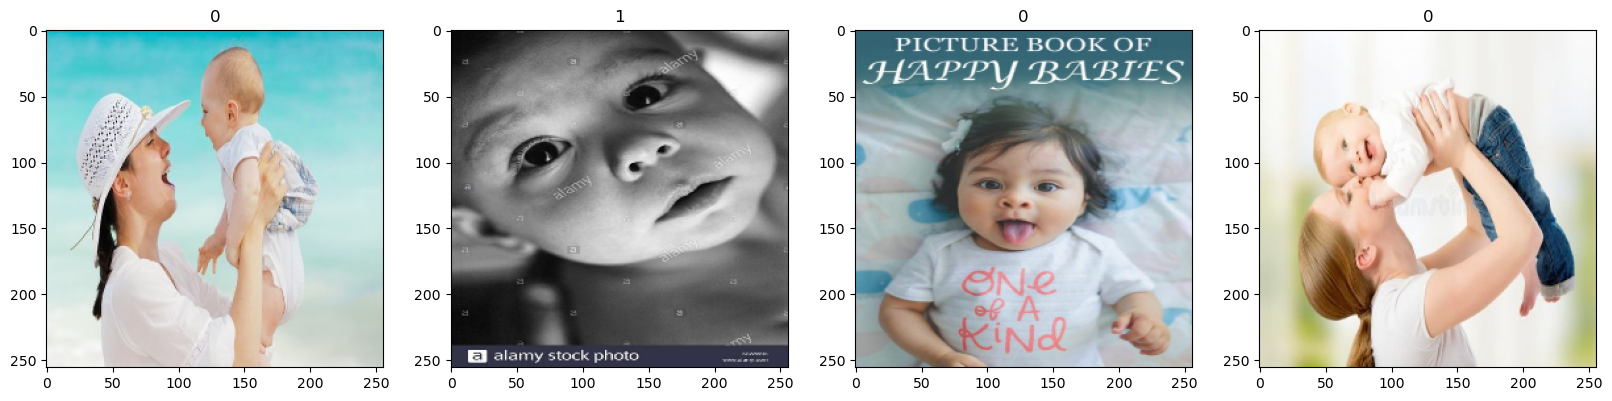

In [31]:
fig,ax =plt.subplots(ncols=4,figsize=(20,20))
for idx,img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

## 2. Pre-Process Data

In [32]:
data =data.map(lambda x,y:(x/255,y))

In [37]:
data.as_numpy_iterator().next()[0].max()

1.0

In [55]:
len(data)

5

In [51]:
train_size=int(len(data)*.7)
val_size=int(len(data)*.2)+1
test_size=int(len(data)*.1)+1

In [54]:
train =data.take(train_size)
test =data.skip(train_size).take(test_size)
val =test.skip(train_size+test_size).take(val_size)

1